In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import collections
from tqdm import trange
import numpy as np
from models.VisionTransformer import VisionTransformerClassifier
from models.stegastamp_wm import StegaStampDecoder, StegaStampEncoder
from evaluate import load
from score import f1, compute_evaluation_metrics
import torch.optim as optim


/Users/varunchitturi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/varunchitturi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/varunchitturi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/varunchitturi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
DATASET_SIZE = 1000
IMAGE_SIZE = 256
NUM_BITS = 48
IMAGE_CHANNELS = 3

if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


coco_dataset_train = datasets.CocoCaptions(root = './data/images/train',
                                     annFile = './data/annotations/train_captions.json',
                                     transform=transforms.Compose([
                                         transforms.Resize(IMAGE_SIZE),
                                         transforms.CenterCrop(IMAGE_SIZE),
                                         transforms.ToTensor()
                                     ]))
coco_dataset_val = datasets.CocoCaptions(root = './data/images/val',
                                           annFile = './data/annotations/val_captions.json',
                                           transform=transforms.Compose([
                                               transforms.Resize(IMAGE_SIZE),
                                               transforms.CenterCrop(IMAGE_SIZE),
                                               transforms.ToTensor()
                                           ]))

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [3]:
signature = torch.randint(0, 2, (1, NUM_BITS), device=device).float()
wm_encoder = StegaStampEncoder(
    IMAGE_SIZE,
    IMAGE_CHANNELS,
    NUM_BITS,
)
wm_encoder_load = torch.load('models/wm_stegastamp_encoder.pth', map_location=device, weights_only=True)
if type(wm_encoder_load) is collections.OrderedDict:
    wm_encoder.load_state_dict(wm_encoder_load)
else:
    wm_encoder = wm_encoder_load

wm_decoder = StegaStampDecoder(
    IMAGE_SIZE,
    IMAGE_CHANNELS,
    NUM_BITS,
)
wm_decoder_load = torch.load('models/wm_stegastamp_decoder.pth', map_location=device, weights_only=True)
if type(wm_decoder_load) is collections.OrderedDict:
    wm_decoder.load_state_dict(wm_decoder_load)
else:
    wm_encoder = wm_encoder_load

wm_encoder.to(device)
wm_decoder.to(device)


StegaStampDecoder(
  (decoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
  )
  (dense): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=48, bias=True)
  )
)

In [4]:
class CocoCaptionWMDataset(Dataset):
    def __init__(self, signature, coco_dataset, num_images):
        super(CocoCaptionWMDataset, self).__init__()
        self.coco_dataset = coco_dataset
        self.dataset = []
        signature_str = "".join([str(x) for x in signature.squeeze().int().tolist()])
        for i in trange(num_images):
            try:
                image, caption = self.coco_dataset[i]
                image = image.to(device).float()
                wm_image = wm_encoder(signature.unsqueeze(0).to(device), image.unsqueeze(0).to(device))
                # self.dataset.append((wm_image, signature_str))
                # self.dataset.append((image.unsqueeze(0).to(device), caption[0]))
                self.dataset.append((wm_image, 0))
                self.dataset.append((image.unsqueeze(0).to(device), 1))
            except Exception as e:
                print(e)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [5]:
train_dataset = CocoCaptionWMDataset(signature, coco_dataset_train, DATASET_SIZE)
val_dataset = CocoCaptionWMDataset(signature, coco_dataset_val, DATASET_SIZE//4)

100%|██████████| 250/250 [00:06<00:00, 39.81it/s]


In [6]:
wm_classifier = VisionTransformerClassifier(input_resolution=train_dataset[0][0].shape[2], layers=2, heads=8, output_dim=2).to(device)

In [7]:
from IPython.display import clear_output
def collate_fn(examples):
    with torch.no_grad():
        images = torch.stack([x[0].squeeze() for x in examples]).squeeze()
        labels = torch.tensor([x[1] for x in examples])
        return (images, labels)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

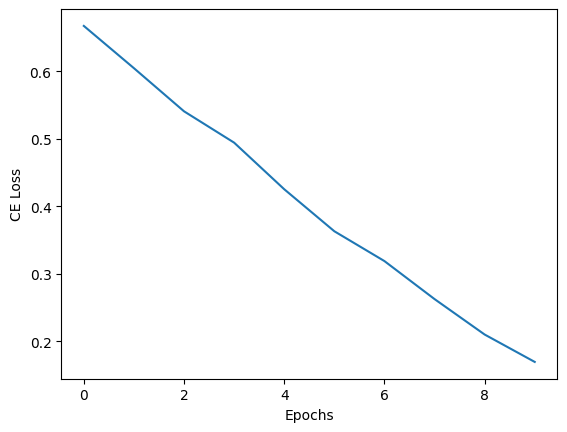

Epoch: 10/10	Loss: 0.1691650952848177


In [8]:
lr = 1e-4
epochs = 10
opt = optim.AdamW(wm_classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
losses = []
for epoch in range(epochs):
    step = 0
    epoch_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        pred_labels = wm_classifier(images)
        loss = criterion(pred_labels, labels)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        step += 1
    epoch_loss = epoch_loss / len(train_loader)
    losses.append(epoch_loss)
    clear_output()
    plt.xlabel("Epochs")
    plt.ylabel("CE Loss")
    plt.plot(losses)
    plt.show()
    print(f"Epoch: {epoch+1}/{epochs}\tLoss: {epoch_loss}")
    

In [9]:
from score import f1
fp = 1e-10
tp = 1e-10
fn = 1e-10
tn = 1e-10
for images, labels in val_loader:
   with torch.no_grad():
      images = images.to(device)
      labels = labels.to(device)
      pred_labels = torch.argmax(wm_classifier(images), dim=-1)
      tp += torch.sum((pred_labels == 1) & (pred_labels == labels)).item()
      tn += torch.sum((pred_labels == 0) & (pred_labels == labels)).item()
      fp += torch.sum((pred_labels == 1) & (pred_labels != labels)).item()
      fn += torch.sum((pred_labels == 0) & (pred_labels != labels)).item()

print(f1(tp, tn, fp, fn))
      

{'Precision': 0.9104477611937236, 'Recall': 0.9759999999996193, 'F1-score': 0.9420849420846006, 'Accuracy': 0.939999999999648}
